# 5. Multiple Regression Analysis: OLS Asymptotics

This notebook explores the asymptotic properties of Ordinary Least Squares (OLS) estimators in multiple regression analysis. Asymptotic theory is crucial because it describes the behavior of estimators as the sample size grows infinitely large ($n \to \infty$). In practice, we often rely on these asymptotic properties to make inferences when sample sizes are reasonably large.

## Asymptotic Properties of OLS

Under the Gauss-Markov assumptions **MLR.1-MLR.4** (from Chapter 3: linearity, random sampling, no perfect collinearity, and zero conditional mean), OLS estimators have the following asymptotic properties:

**1. Consistency:** $\hat{\beta}_j \xrightarrow{p} \beta_j$ as $n \to \infty$ for all $j = 0, 1, \ldots, k$

The OLS estimators converge in probability to the true parameter values as the sample size grows large. Consistency is a weaker property than unbiasedness—it only requires that the estimator approaches the true value asymptotically. Notably, consistency does **not** require normality (MLR.6) or homoscedasticity (MLR.5).

**2. Asymptotic Normality:** $\sqrt{n}(\hat{\beta}_j - \beta_j) \xrightarrow{d} N(0, \sigma^2_{\beta_j})$ as $n \to \infty$

By the **Central Limit Theorem (CLT)**, the sampling distribution of $\hat{\beta}_j$ approaches a normal distribution as $n \to \infty$, even when the errors are **not** normally distributed. This requires:
- MLR.1-MLR.4 (especially zero conditional mean)
- Finite fourth moments of the errors: $E(u^4) < \infty$ (mild regularity condition)
- **No normality assumption required**

**Practical Implications:**
- With large samples ($n \geq 30$ typically), t-tests and F-tests are approximately valid even without normal errors (MLR.6)
- Consistency means OLS remains reliable in large samples even under violations of MLR.5 (heteroskedasticity)
- Asymptotic inference requires only MLR.1-MLR.4 plus regularity conditions, making it more robust than finite-sample inference

We will use simulations to visualize these concepts and then apply the Lagrange Multiplier (LM) test to a real-world example.

**Connection to Previous Chapters:**
- Chapters 2-3 established finite-sample properties under Gauss-Markov assumptions
- Chapter 4 showed exact inference requires normality (MLR.6) for finite samples
- This chapter demonstrates that normality is **not necessary** for large-sample inference
- These results justify the robustness claims made in Chapter 4 about t-tests with $n \geq 30$



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import wooldridge as woo
from scipy import stats

## 5.1 Simulation Exercises

In this section, we will conduct simulation exercises to illustrate the asymptotic properties of the OLS estimator, particularly focusing on its distribution as the sample size increases under different scenarios.

### 5.1.1 Normally Distributed Error Terms

This simulation demonstrates the behavior of the OLS estimator when the error terms are normally distributed.  Under the classical linear model assumptions, including normally distributed errors, the OLS estimators are not only BLUE (Best Linear Unbiased Estimator) but also have desirable properties even in small samples. Asymptotically, the OLS estimator is consistent and normally distributed. We will visualize how the distribution of the estimated coefficient $\hat{\beta}_1$ approaches a normal distribution as the sample size $n$ increases.

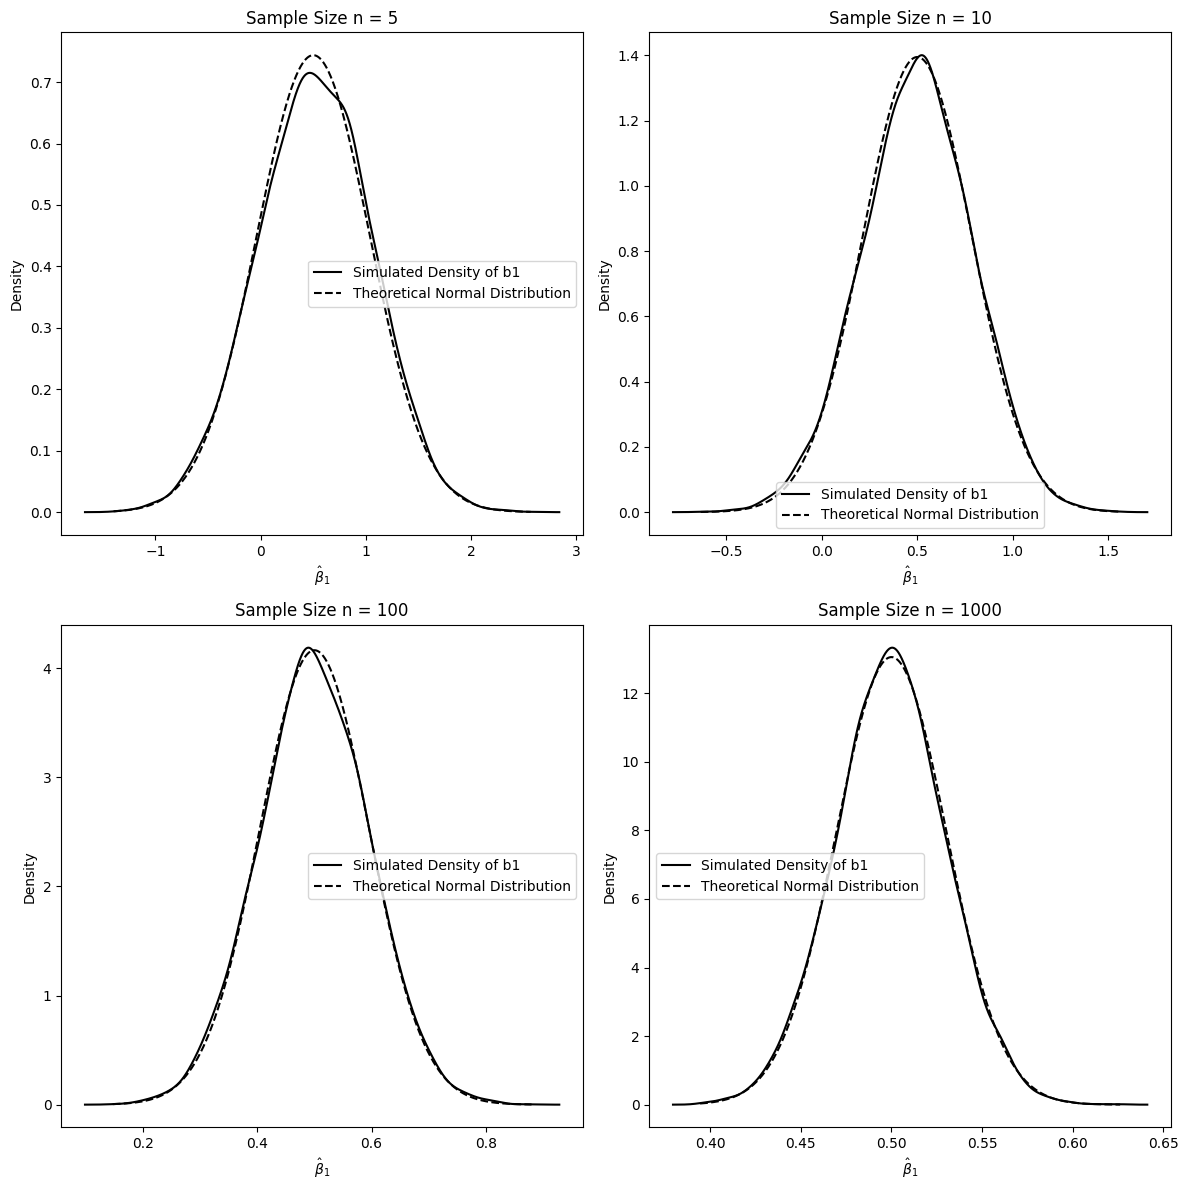

In [2]:
# Monte Carlo Simulation Setup: OLS with Normal Errors
# Demonstrates convergence to normality as sample size increases

# Set random seed for reproducible results
np.random.seed(1234567)

# Configure simulation parameters
sample_sizes = [5, 10, 100, 1000]  # n: Small to large samples
num_replications = 10000  # r: Number of Monte Carlo iterations

# Define true population parameters (Data Generating Process)
# True model: y = β₀ + β₁x + u, where u ~ N(0, 1)
true_intercept = 1.0  # β₀ = 1
true_slope = 0.5  # β₁ = 0.5
x_std_dev = 1.0  # σₓ: Standard deviation of x
x_mean = 4.0  # μₓ: Mean of x

print("SIMULATION 1: OLS WITH NORMAL ERRORS")
print("-" * 40)
print(f"DGP: y = {true_intercept} + {true_slope}*x + u")
print(f"X ~ N({x_mean}, {x_std_dev}²), u ~ N(0, 1)")
print(f"Replications: {num_replications:,}\n")

# Create visualization grid for results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()  # Flatten for easier iteration

# Run simulation for each sample size
for idx, n in enumerate(sample_sizes):
    # Step 1: Generate fixed x values for this sample size
    # X is held constant across replications to isolate error term effects
    x_values = stats.norm.rvs(x_mean, x_std_dev, size=n)

    # Step 2: Generate error terms for all replications
    # Shape: (num_replications, n) - each row is one replication
    error_terms = stats.norm.rvs(0, 1, size=(num_replications, n))

    # Step 3: Generate y values using true DGP
    # y = β₀ + β₁*x + u for each replication
    y_values = true_intercept + true_slope * x_values + error_terms

    # Step 4: Construct design matrix X (same for all replications)
    # X = [1, x] where first column is for intercept
    X_matrix = np.column_stack((np.ones(n), x_values))

    # Step 5: Pre-compute matrix operations for efficiency
    # (X'X)^(-1)X' is constant across replications since X is fixed
    XtX_inv = np.linalg.inv(X_matrix.T @ X_matrix)
    XtX_inv_Xt = XtX_inv @ X_matrix.T

    # Step 6: Estimate coefficients for all replications at once
    # β̂ = (X'X)^(-1)X'y for each replication
    # Result: 2 × num_replications matrix (each column = one replication)
    all_coefficients = XtX_inv_Xt @ y_values.T
    slope_estimates = all_coefficients[1, :]  # Extract β̂₁ (second row)

    # Step 7: Calculate theoretical standard error for comparison
    # Under CLM assumptions: Var(β̂) = σ²(X'X)^(-1), where σ² = 1
    variance_matrix = XtX_inv  # Since σ² = 1
    theoretical_se = np.sqrt(variance_matrix[1, 1])  # SE(β̂₁)

    # Step 8: Estimate empirical density using kernel density estimation
    kde = sm.nonparametric.KDEUnivariate(slope_estimates)
    kde.fit()

    # Step 9: Generate theoretical normal distribution for comparison
    x_range = np.linspace(min(slope_estimates), max(slope_estimates), 1000)
    theoretical_density = stats.norm.pdf(x_range, true_slope, theoretical_se)

    # Step 10: Plot empirical vs theoretical distributions
    axes[idx].plot(
        kde.support,
        kde.density,
        color="black",
        linewidth=2,
        label="Empirical Density (KDE)",
    )
    axes[idx].plot(
        x_range,
        theoretical_density,
        linestyle="--",
        color="red",
        linewidth=1.5,
        label="Theoretical Normal",
    )

    # Add visualization details
    axes[idx].set_ylabel("Density")
    axes[idx].set_xlabel(r"$\hat{\beta}_1$ (Slope Estimate)")
    axes[idx].legend(loc="best", fontsize=9)
    axes[idx].set_title(f"Sample Size n = {n}")
    axes[idx].grid(True, alpha=0.3)

    # Add statistics annotation
    mean_est = np.mean(slope_estimates)
    std_est = np.std(slope_estimates)
    axes[idx].text(
        0.05,
        0.95,
        f"Mean: {mean_est:.4f}\nStd: {std_est:.4f}",
        transform=axes[idx].transAxes,
        verticalalignment="top",
        fontsize=8,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

plt.suptitle("Convergence to Normality: OLS with Normal Errors", fontsize=14)
plt.tight_layout()
plt.show()  # Display the plot

**Interpretation of 5.1.1:**

The plots above show the simulated density of the OLS estimator $\hat{\beta}_1$ for different sample sizes ($n = 5, 10, 100, 1000$) when the error term is normally distributed.  We compare this simulated density to the theoretical normal distribution that $\hat{\beta}_1$ should asymptotically follow.

- **Small Sample Sizes (n=5, 10):** For very small sample sizes, the simulated density of $\hat{\beta}_1$ is somewhat close to the normal distribution, but there are noticeable deviations. This is because while OLS is BLUE under these conditions, the asymptotic normality is approached as $n \rightarrow \infty$.

- **Larger Sample Sizes (n=100, 1000):** As the sample size increases to $n=100$ and $n=1000$, the simulated density of $\hat{\beta}_1$ gets increasingly closer to the theoretical normal distribution.  For $n=1000$, the simulated density is almost indistinguishable from the normal distribution.

This simulation visually confirms that when the errors are normally distributed, the distribution of the OLS estimator $\hat{\beta}_1$ approaches a normal distribution as the sample size $n$ increases, consistent with asymptotic theory and even showing reasonable approximation for smaller sample sizes in this ideal scenario.

### 5.1.2 Non-Normal Error Terms

In this simulation, we investigate what happens when one of the classical linear model assumptions is violated – specifically, the assumption of normally distributed errors. We will use error terms that follow a standardized Chi-squared distribution with 1 degree of freedom.  Even when the error term is not normally distributed, under the Gauss-Markov conditions and assuming homoskedasticity and no autocorrelation, OLS is still BLUE. More importantly, even with non-normal errors, the OLS estimator is still consistent and asymptotically normally distributed under weaker conditions (CLT for sample averages). This simulation will demonstrate the asymptotic normality even with non-normal errors.

First, let's visualize the shape of the standardized Chi-squared distribution compared to the standard normal distribution.

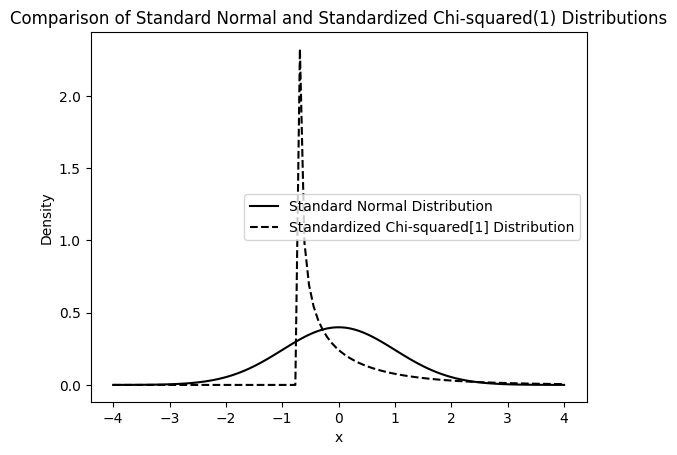

In [3]:
# support of normal density:
x_range = np.linspace(-4, 4, num=100)

# pdf for standard normal distribution:
pdf_n = stats.norm.pdf(x_range)
# pdf for standardized chi-squared distribution with 1 degree of freedom.
# We subtract the mean (which is 1 for chi2(1)) and divide by the standard deviation (which is sqrt(2) for chi2(1)) to standardize it.
pdf_c = stats.chi2.pdf(x_range * np.sqrt(2) + 1, 1)

# plot:
plt.plot(
    x_range,
    pdf_n,
    linestyle="-",
    color="black",
    label="Standard Normal Distribution",
)
plt.plot(
    x_range,
    pdf_c,
    linestyle="--",
    color="black",
    label="Standardized Chi-squared[1] Distribution",
)
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.title("Comparison of Standard Normal and Standardized Chi-squared(1) Distributions")
plt.show()

The plot above shows that the standardized Chi-squared distribution is skewed to the right and has a different shape compared to the standard normal distribution. Now, let's perform the simulation with these non-normal errors.

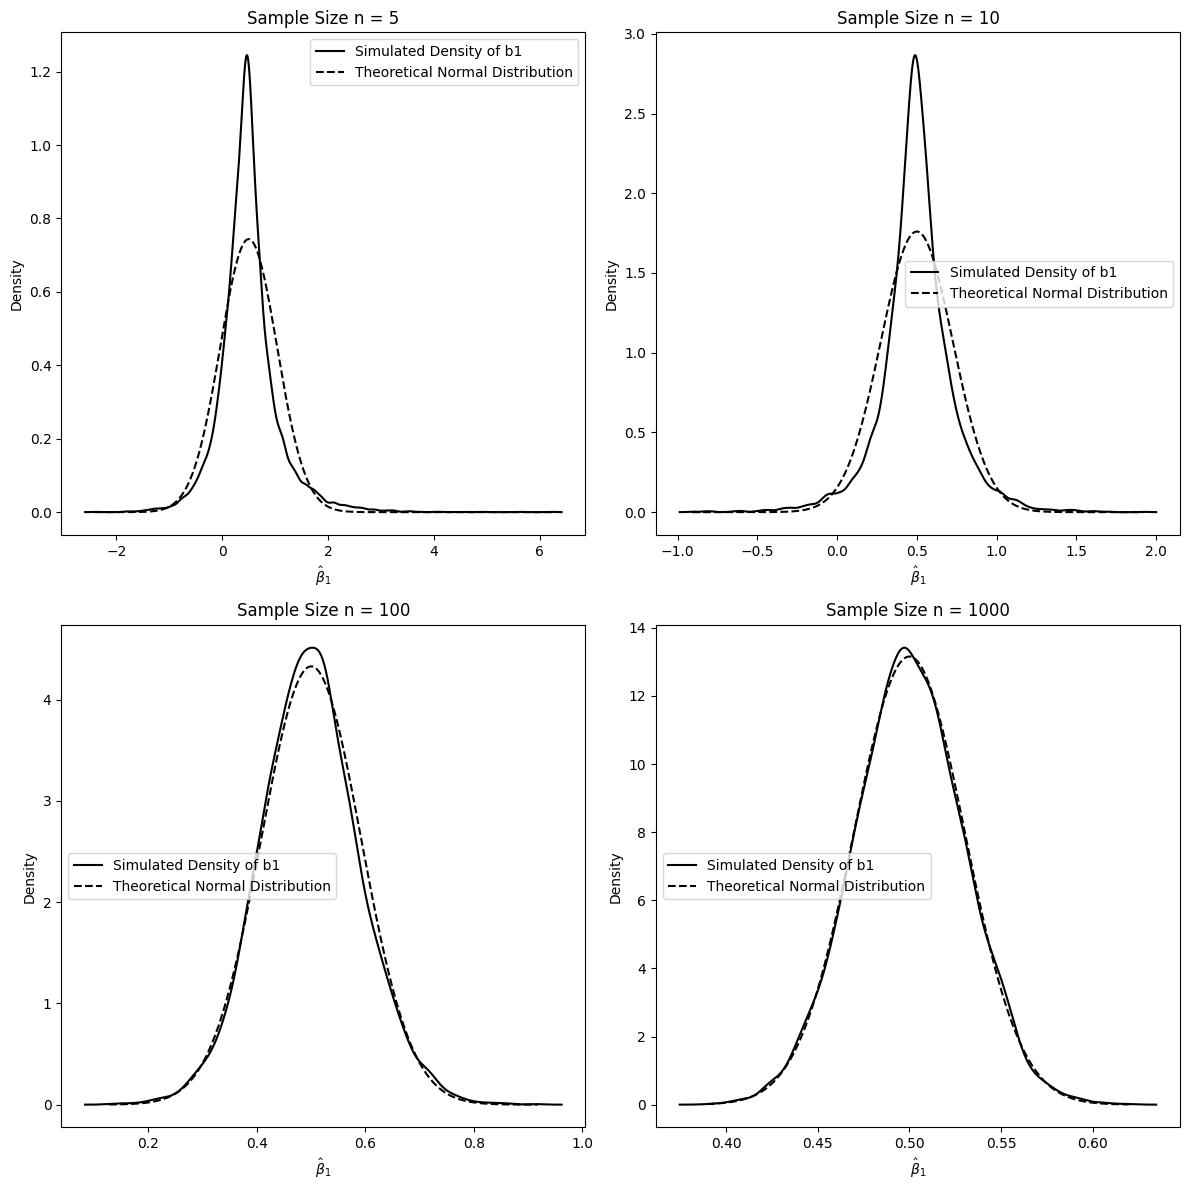

In [4]:
# set the random seed for reproducibility:
np.random.seed(1234567)

# set sample sizes to be investigated:
n = [5, 10, 100, 1000]
# set number of simulations (replications):
r = 10000

# set true population parameters:
beta0 = 1  # true intercept
beta1 = 0.5  # true slope coefficient
sx = 1  # standard deviation of x
ex = 4  # expected value of x

# Create a 2x2 subplot to display density plots for each sample size
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()  # Flatten the 2x2 array of axes for easier indexing

# Loop through each sample size in the list 'n'
for idx, j in enumerate(n):
    # draw a sample of x, fixed over replications:
    x = stats.norm.rvs(ex, sx, size=j)

    # Create the design matrix X. For each replication, X is the same as 'x' is fixed.
    X = np.column_stack((np.ones(j), x))

    # Compute (X'X)^(-1)X' once as X is fixed for each n.
    XX_inv = np.linalg.inv(X.T @ X)
    XTX_inv_XT = XX_inv @ X.T

    # Generate error terms 'u' from a standardized Chi-squared distribution with 1 degree of freedom for all replications at once.
    u = (stats.chi2.rvs(1, size=(r, j)) - 1) / np.sqrt(2)

    # Compute the dependent variable 'y' for all replications at once using the true model: y = beta0 + beta1*x + u
    y = beta0 + beta1 * x + u

    # Estimate beta (including beta0 and beta1) for all 'r' replications at once.
    b = XTX_inv_XT @ y.T
    b1 = b[1, :]  # Extract all estimated beta1 coefficients.

    # Estimate the PDF of the simulated b1 estimates using Kernel Density Estimation (KDE).
    kde = sm.nonparametric.KDEUnivariate(b1)
    kde.fit()

    # Theoretical normal density, calculated the same way as in the normal error case.
    Vbhat = XX_inv  # Variance-covariance matrix
    se = np.sqrt(np.diagonal(Vbhat))
    x_range = np.linspace(min(b1), max(b1), 1000)
    y = stats.norm.pdf(x_range, beta1, se[1])

    # plotting:
    axs[idx].plot(
        kde.support,
        kde.density,
        color="black",
        label="Simulated Density of b1",
    )
    axs[idx].plot(
        x_range,
        y,
        linestyle="--",
        color="black",
        label="Theoretical Normal Distribution",
    )
    axs[idx].set_ylabel("Density")
    axs[idx].set_xlabel(r"$\hat{\beta}_1$")
    axs[idx].legend()
    axs[idx].set_title(f"Sample Size n = {j}")

plt.tight_layout()
plt.show()

**Interpretation of 5.1.2:**

These plots illustrate the distribution of $\hat{\beta}_1$ when the error terms are from a standardized Chi-squared distribution, which is non-normal.

- **Small Sample Sizes (n=5, 10):** For small sample sizes, the simulated density of $\hat{\beta}_1$ is noticeably skewed and deviates from the normal distribution, reflecting the non-normality of the error term.

- **Larger Sample Sizes (n=100, 1000):** As the sample size increases, the simulated density of $\hat{\beta}_1$ becomes progressively more symmetric and approaches the theoretical normal distribution. By $n=1000$, the simulated distribution is very close to normal, even though the underlying errors are non-normal.

This simulation demonstrates the power of the Central Limit Theorem in action. Even when the errors are not normally distributed, the OLS estimator $\hat{\beta}_1$, which is a function of the sample average of the error terms (indirectly), becomes approximately normally distributed as the sample size grows large. This is a key result in asymptotic theory, justifying the use of normal distribution based inference (t-tests, confidence intervals) in OLS regression with large samples, even if we suspect the errors are not normally distributed.

### 5.1.3 (Not) Conditioning on the Regressors

In previous simulations (5.1.1 and 5.1.2), we fixed the regressors $x$ across replications for each sample size $n$. This is akin to *conditioning on the regressors*. In econometric theory, we often derive properties of OLS estimators *conditional* on the observed values of the regressors. However, in reality, regressors are also random variables. This simulation explores the implications of *not conditioning* on the regressors by drawing new samples of $x$ in each replication, along with new error terms. We will see if the asymptotic normality of $\hat{\beta}_1$ still holds when both $x$ and $u$ are randomly drawn in each simulation run.

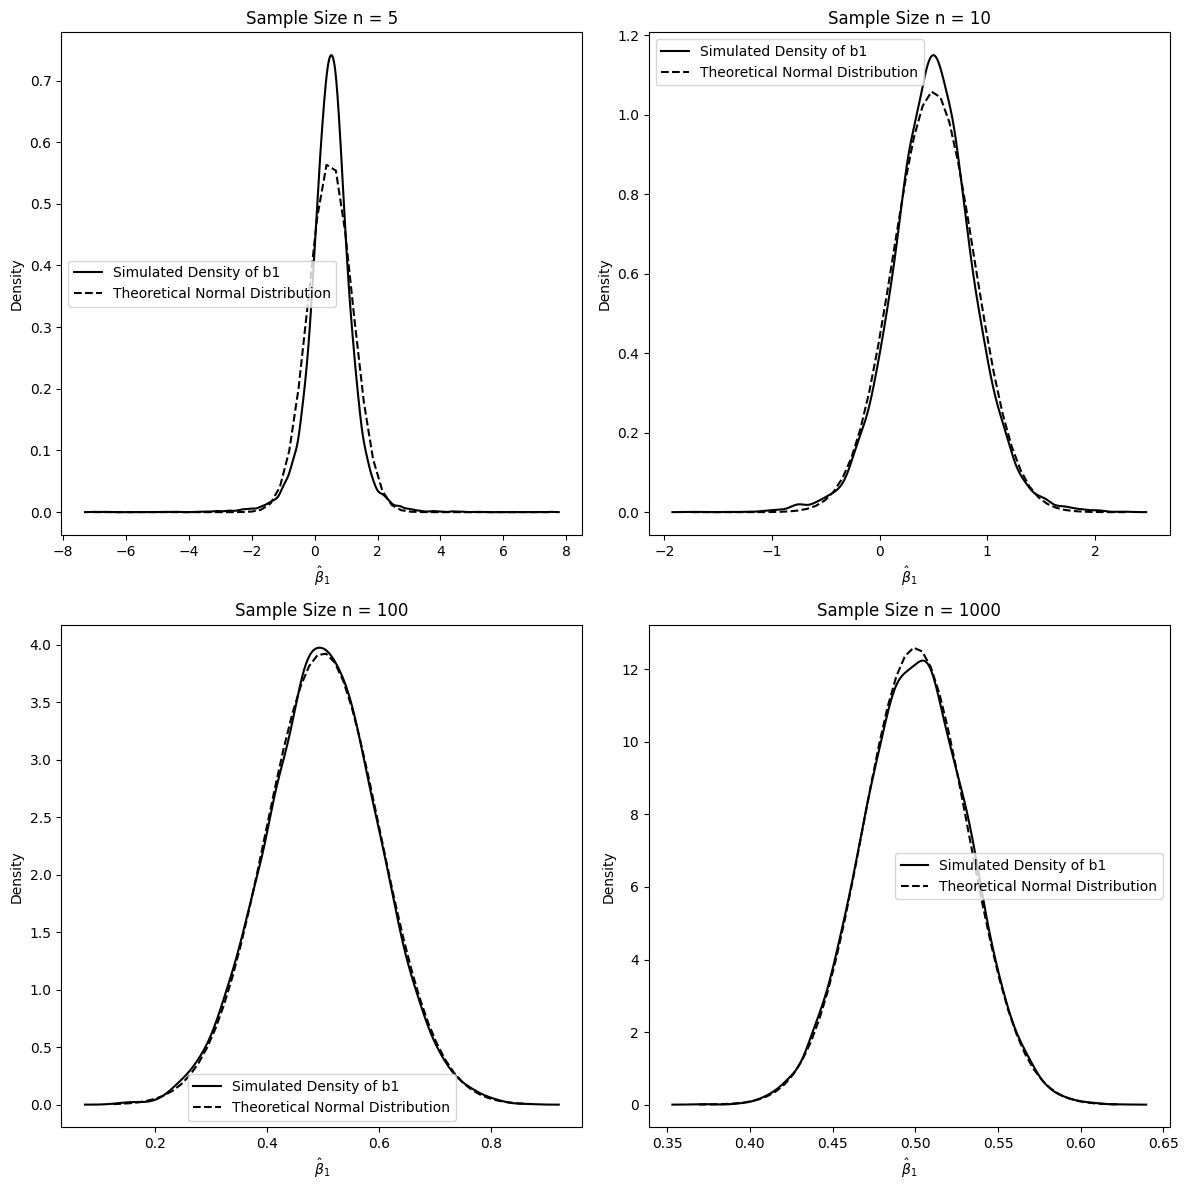

In [5]:
# set the random seed for reproducibility:
np.random.seed(1234567)

# set sample sizes to be investigated:
n = [5, 10, 100, 1000]
# set number of simulations (replications):
r = 10000

# set true population parameters:
beta0 = 1  # true intercept
beta1 = 0.5  # true slope coefficient
sx = 1  # standard deviation of x
ex = 4  # expected value of x

# Create a 2x2 subplot to display density plots for each sample size
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()  # Flatten the 2x2 array of axes for easier indexing

# Loop through each sample size in the list 'n'
for idx, j in enumerate(n):
    # initialize b1 to store results later:
    b1 = np.empty(r)
    XX_inv_list = []  # To store (X'X)^-1 for each replication

    # draw a sample of x, varying over replications:
    x = stats.norm.rvs(ex, sx, size=(r, j))
    # draw a sample of u (std. normal):
    u = stats.norm.rvs(0, 1, size=(r, j))
    y = beta0 + beta1 * x + u
    # repeat r times:
    for i in range(r):
        # Create design matrix X
        X = np.column_stack((np.ones(j), x[i]))

        # Compute (X'X)^(-1)
        XX_inv = np.linalg.inv(X.T @ X)
        XX_inv_list.append(XX_inv)  # Store (X'X)^-1 for averaging
        XTX_inv_XT = XX_inv @ X.T  # Unused in variance calc, but used for beta

        # Estimate beta for all replications at once
        b = XTX_inv_XT @ y[i].T
        b1[i] = b[1]

    # simulated density:
    kde = sm.nonparametric.KDEUnivariate(b1)
    kde.fit()
    # normal density/ compute mu and se
    # Average (X'X)^-1 over replications
    avg_XX_inv = np.mean(np.array(XX_inv_list), axis=0)
    Vbhat = sx * avg_XX_inv  # Use averaged (X'X)^-1
    se = np.sqrt(np.diagonal(Vbhat))
    x_range = np.linspace(min(b1), max(b1))
    y = stats.norm.pdf(x_range, beta1, se[1])
    # plotting:
    axs[idx].plot(
        kde.support,
        kde.density,
        color="black",
        label="Simulated Density of b1",
    )
    axs[idx].plot(
        x_range,
        y,
        linestyle="--",
        color="black",
        label="Theoretical Normal Distribution",
    )
    axs[idx].set_ylabel("Density")
    axs[idx].set_xlabel(r"$\hat{\beta}_1$")
    axs[idx].legend()
    axs[idx].set_title(f"Sample Size n = {j}")

plt.tight_layout()
plt.show()

**Interpretation of 5.1.3:**

In this simulation, both the regressors $x$ and the error terms $u$ are randomly drawn in each replication.

- **Small Sample Sizes (n=5, 10):** Similar to the previous simulations, with very small sample sizes, the simulated distribution of $\hat{\beta}_1$ shows some deviation from the normal distribution.

- **Larger Sample Sizes (n=100, 1000):** As the sample size increases, even when we are not conditioning on the regressors, the distribution of $\hat{\beta}_1$ still converges to a normal distribution. By $n=1000$, the convergence is quite evident.

This simulation reinforces the asymptotic normality of the OLS estimator even when we consider the randomness of the regressors. The key conditions for asymptotic normality are related to the properties of the population and the law of large numbers and central limit theorem applying to sample averages, which hold true whether we condition on regressors or not, as long as certain regularity conditions are met (like finite variance of $x$ and $u$, and exogeneity). This is fundamental because in most econometric applications, regressors are indeed random variables.

## 5.2 LM Test

The Lagrange Multiplier (LM) test, also known as the score test, is a statistical test used to test hypotheses in the context of constrained optimization. In econometrics, it is often used to test for omitted variables or other forms of model misspecification. It is particularly useful because it only requires estimation of the *restricted* model (the model under the null hypothesis).

For testing restrictions in a linear regression model, the LM test statistic is often computationally simpler than the Wald or Likelihood Ratio tests, especially when the null hypothesis involves restrictions on coefficients.

For testing $q$ restrictions of the form $H_0: R\beta = r$ in a linear regression, where $R$ is a $q \times (k+1)$ matrix and $r$ is a $q \times 1$ vector, the LM test statistic can be calculated as:

$$ \text{LM} = n \cdot R^2_{\tilde{u}} \sim \chi^2_q \text{ asymptotically under } H_0$$

where:
- $n$ is the sample size.
- $R^2_{\tilde{u}}$ is the R-squared from a regression of the residuals from the restricted model ($\tilde{u}$) on all the independent variables in the *unrestricted* model.
- $q$ is the number of restrictions being tested (degrees of freedom).
- $\chi^2_q$ denotes a Chi-squared distribution with $q$ degrees of freedom.

The steps to perform an LM test are typically as follows:

1. **Estimate the Restricted Model:** Estimate the regression model under the null hypothesis. Obtain the residuals from this restricted model ($\tilde{u}$).
2. **Auxiliary Regression:** Regress the residuals $\tilde{u}$ from the restricted model on all the independent variables from the *unrestricted* model. Calculate the $R^2$ from this auxiliary regression ($R^2_{\tilde{u}}$).
3. **Calculate the LM Statistic:** Compute the LM test statistic as $LM = n \cdot R^2_{\tilde{u}}$.
4. **Determine the p-value:** Compare the LM statistic to a $\chi^2_q$ distribution, where $q$ is the number of restrictions. Calculate the p-value or compare the LM statistic to a critical value from the $\chi^2_q$ distribution to make a decision.

### Example 5.3: Economic Model of Crime

We will use the `crime1` dataset from the `wooldridge` package to illustrate the LM test. The example considers an economic model of crime where the number of arrests (`narr86`) is modeled as a function of several factors.

The unrestricted model is:

$$\text{narr86} = \beta_0 + \beta_1 \cdot \text{pcnv} + \beta_2 \cdot \text{avgsen} + \beta_3 \cdot \text{tottime} + \beta_4 \cdot \text{ptime86} + \beta_5 \cdot \text{qemp86} + u$$

We want to test the null hypothesis that `avgsen` (average sentence length) and `tottime` (total time served) have no effect on `narr86`, i.e., $H_0: \beta_2 = 0 \text{ and } \beta_3 = 0$.  Thus, we have $q=2$ restrictions.

The restricted model under $H_0$ is:

$$\text{narr86} = \beta_0 + \beta_1 \cdot \text{pcnv} + \beta_4 \cdot \text{ptime86} + \beta_5 \cdot \text{qemp86} + u$$

In [6]:
crime1 = woo.dataWoo("crime1")

# 1. Estimate the restricted model under H0: beta_avgsen = 0 and beta_tottime = 0
reg_r = smf.ols(formula="narr86 ~ pcnv + ptime86 + qemp86", data=crime1)
fit_r = reg_r.fit()
r2_r = fit_r.rsquared
print(f"R-squared of Restricted Model (r2_r): {r2_r:.4f}\n")

R-squared of Restricted Model (r2_r): 0.0413



In [7]:
# 2. Obtain residuals from the restricted model and add them to the DataFrame
crime1["utilde"] = fit_r.resid

# 3. Run auxiliary regression: regress residuals (utilde) on ALL variables from the UNRESTRICTED model
reg_LM = smf.ols(
    formula="utilde ~ pcnv + ptime86 + qemp86 + avgsen + tottime",
    data=crime1,
)
fit_LM = reg_LM.fit()
r2_LM = fit_LM.rsquared
print(f"R-squared of LM Regression (r2_LM): {r2_LM:.4f}\n")

R-squared of LM Regression (r2_LM): 0.0015



In [8]:
# 4. Calculate the LM test statistic: LM = n * R^2_utilde
LM = r2_LM * fit_LM.nobs
print(f"LM Test Statistic: {LM:.3f}\n")

LM Test Statistic: 4.071



In [9]:
# 5. Determine the critical value from the chi-squared distribution with q=2 degrees of freedom at alpha=10% significance level
# For a test at 10% significance level, alpha = 0.10.
# We want to find the chi-squared value such that the area to the right is 0.10.
cv = stats.chi2.ppf(1 - 0.10, 2)  # ppf is the percent point function (inverse of CDF)
print(f"Critical Value (Chi-squared with 2 df, alpha=0.10): {cv:.3f}\n")

Critical Value (Chi-squared with 2 df, alpha=0.10): 4.605



In [10]:
# 6. Calculate the p-value for the LM test
# The p-value is the probability of observing a test statistic as extreme as, or more extreme than, the one calculated, under the null hypothesis.
pval = 1 - stats.chi2.cdf(LM, 2)  # cdf is the cumulative distribution function
print(f"P-value for LM Test: {pval:.4f}\n")

P-value for LM Test: 0.1306



In [11]:
# 7. Compare the LM test to the F-test for the same hypothesis using the unrestricted model directly.
reg = smf.ols(
    formula="narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86",
    data=crime1,
)
results = reg.fit()
# Define the hypotheses to be tested: beta_avgsen = 0 and beta_tottime = 0
hypotheses = ["avgsen = 0", "tottime = 0"]
# Perform the F-test
ftest = results.f_test(hypotheses)
fstat = ftest.statistic
fpval = ftest.pvalue
print(f"F-statistic: {fstat:.3f}\n")
print(f"P-value for F-test: {fpval:.4f}\n")

F-statistic: 2.034

P-value for F-test: 0.1310



**Interpretation of Example 5.3:**

- **LM Test Statistic:** The calculated LM test statistic is 4.071.
- **Critical Value:** The critical value from the $\chi^2_2$ distribution at the 10% significance level is 4.605.
- **P-value:** The p-value for the LM test is 0.1306.

Since the LM test statistic (4.071) is less than the critical value (4.605), or equivalently, the p-value (0.1306) is greater than the significance level (0.10), we fail to reject the null hypothesis $H_0: \beta_2 = 0 \text{ and } \beta_3 = 0$.  This suggests that `avgsen` and `tottime` are jointly statistically insignificant in explaining `narr86`, given the other variables in the model.

- **Comparison with F-test:** The F-test directly tests the same hypothesis using the unrestricted model. The F-statistic is 2.034 and the p-value is 0.1310.

The results from the LM test and the F-test are very similar in this case, leading to the same conclusion: we fail to reject the null hypothesis.  In linear regression models, under homoskedasticity, the LM test, Wald test, and F-test are asymptotically equivalent for testing linear restrictions on the coefficients. In practice, especially with reasonably large samples, these tests often provide similar conclusions. The LM test is advantageous when estimating the unrestricted model is more complex or computationally intensive, as it only requires estimating the restricted model.

**Conclusion:**

This notebook has explored the asymptotic properties of OLS estimators through simulations and demonstrated the application of the Lagrange Multiplier (LM) test. The simulations visually confirmed the asymptotic normality of OLS estimators even under non-normal errors and when regressors are random. The LM test example provided a practical application of hypothesis testing within the framework of linear regression, showing its usefulness as an alternative to the F-test, particularly in situations where estimating only the restricted model is beneficial. Understanding these asymptotic properties and testing procedures is crucial for conducting sound econometric analysis and making valid inferences from regression models, especially when dealing with large datasets where asymptotic theory becomes increasingly relevant.